# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [628]:
import pandas as pd
import numpy as np
import math
import json
import ast
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [422]:
portfolio_copy = portfolio.copy()
profile_copy = profile.copy()
transcript_copy = transcript.copy()

### Loading and Cleaning Data

#### Portfolio Data

In [423]:
portfolio = portfolio.rename(columns={'id':'offer id'})
portfolio

,channels,difficulty,duration,offer id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [424]:
#one hot encoding the channel level data
portfolio['web'] = portfolio.channels.apply(lambda x: 1 if 'web' in x else 0)
portfolio['mobile'] = portfolio.channels.apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['email'] = portfolio.channels.apply(lambda x: 1 if 'email' in x else 0)
portfolio['social'] = portfolio.channels.apply(lambda x: 1 if 'social' in x else 0)

In [425]:
portfolio

,channels,difficulty,duration,offer id,offer_type,reward,web,mobile,email,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


#### Profile Data

In [426]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [427]:
#chaning the date format to YYYY-MM-DD and "id" to "customer_id"
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile = profile.rename(columns={'id':'customer_id'})

In [428]:
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [429]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

#### Transcript Data

In [430]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [431]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [432]:
transcript["Dictionary Length"] = transcript.apply(lambda x: len(x["value"]), axis=1)
transcript["Dictionary Length"].value_counts()

1    272955
2     33579
Name: Dictionary Length, dtype: int64

In [433]:
transcript["Dictionary Keys"] = transcript.apply(lambda x: str(x["value"].keys()), axis=1)
transcript["Dictionary Keys"].unique() #to find the unique keys of the dictionary format data in the "value" column

array(["dict_keys(['offer id'])", "dict_keys(['amount'])",
       "dict_keys(['offer_id', 'reward'])"], dtype=object)

In [434]:
dummy = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, dummy], axis=1 )

In [435]:
#extracting "offer_id", "amount", "reward" from the "value" column
transcript['offer id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]

for j in tqdm.tqdm(range(len(transcript))):
    
    if transcript["Dictionary Length"][j]==2:
        dict_ = transcript["value"][j]
        transcript['reward'] = dict_["reward"]
        
transcript["reward"].unique() #since there is only 1 value in the reward column we will drop it

100%|██████████| 306534/306534 [00:28<00:00, 10775.52it/s]


array([2])

In [436]:
transcript.drop(["value", "Dictionary Length", "Dictionary Keys", "reward"], axis=1, inplace=True)
transcript.head()

,event,person,time,offer completed,offer received,offer viewed,transaction,offer id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [437]:
transcript.isna().sum()

event                   0
person                  0
time                    0
offer completed         0
offer received          0
offer viewed            0
transaction             0
offer id           138953
amount             167581
dtype: int64

In [438]:
#renaming "person" to "customer_id"
transcript = transcript.rename(columns={'person':'customer_id'})
transcript.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [439]:
profile["customer_id"].nunique()

17000

In [440]:
transcript["customer_id"].nunique()

17000

### Merging the datasets

In [330]:
#merging transcript and profile data using "customer_id"
t_p = pd.merge(transcript, profile, on='customer_id')
t_p["customer_id"].isna().sum()

0

In [331]:
#merging transcript and profile data with portfolio data using "offer id"
final_df = pd.merge(t_p, portfolio, on='offer id', how="left")
final_df.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,...,income,channels,difficulty,duration,offer_type,reward,web,mobile,email,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
#Creating a dictionary to rename the offer ids to integer values (for ease of readability)
offer_id = final_df['offer id'].unique()
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [333]:
final_df['offer id'] = final_df['offer id'].map(offer_dict)
final_df.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,...,income,channels,difficulty,duration,offer_type,reward,web,mobile,email,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,1,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,1,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [334]:
final_df['offer id'] = final_df['offer id'].replace(1, np.nan)
final_df.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,...,income,channels,difficulty,duration,offer_type,reward,web,mobile,email,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,...,100000.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
#creating event ids corresponding to individual events
event_ids = final_df['event'].unique()
event_dict = pd.Series(event_ids).to_dict()
event_dict = dict([(value, key) for key, value in event_dict.items()]) 
event_dict

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3}

In [336]:
#map event_ids to the encoded event ids
final_df['event_id'] = final_df['event'].map(event_dict)

In [337]:
final_df.dtypes

event                       object
customer_id                 object
time                         int64
offer completed              uint8
offer received               uint8
offer viewed                 uint8
transaction                  uint8
offer id                   float64
amount                     float64
age                          int64
became_member_on    datetime64[ns]
gender                      object
income                     float64
channels                    object
difficulty                 float64
duration                   float64
offer_type                  object
reward                     float64
web                        float64
mobile                     float64
email                      float64
social                     float64
event_id                     int64
dtype: object

In [338]:
final_df.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,...,channels,difficulty,duration,offer_type,reward,web,mobile,email,social,event_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,...,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,...,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,...,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [339]:
final_df[final_df["transaction"]==1].describe()

,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,income,difficulty,duration,reward,web,mobile,email,social,event_id
count,138953.000000,138953.0,138953.0,138953.0,138953.0,0.0,138953.000000,138953.000000,123957.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138953.0
mean,381.584334,0.0,0.0,0.0,1.0,NaN,12.777356,59.759725,61843.510250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
std,201.697230,0.0,0.0,0.0,0.0,NaN,30.250529,26.389269,20661.890394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,0.000000,0.0,0.0,0.0,1.0,NaN,0.050000,18.000000,30000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
25%,210.000000,0.0,0.0,0.0,1.0,NaN,2.780000,41.000000,46000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
50%,402.000000,0.0,0.0,0.0,1.0,NaN,8.890000,56.000000,60000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
75%,552.000000,0.0,0.0,0.0,1.0,NaN,18.070000,71.000000,74000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
max,714.000000,0.0,0.0,0.0,1.0,NaN,1062.280000,118.000000,120000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [340]:
final_df.head()

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,...,channels,difficulty,duration,offer_type,reward,web,mobile,email,social,event_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75,...,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75,...,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,19.89,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,NaN,75,...,"[web, email, mobile]",5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,17.78,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [341]:
[*final_df.columns] #printing the list of columns

['event',
 'customer_id',
 'time',
 'offer completed',
 'offer received',
 'offer viewed',
 'transaction',
 'offer id',
 'amount',
 'age',
 'became_member_on',
 'gender',
 'income',
 'channels',
 'difficulty',
 'duration',
 'offer_type',
 'reward',
 'web',
 'mobile',
 'email',
 'social',
 'event_id']

In [342]:
final_df.to_csv('final_data.csv', index=False)

### EDA

### 1. On Customer Demographics

#### For Age


- Max. age is 118 which doesn't look good
- On further investigation it was found that when "income" is a nan value then the age is 118 (could be considered as nan)
- Therefore, age 118 was replace with nan values
- Average age of a customer is ~54

In [343]:
final_df["age"].describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

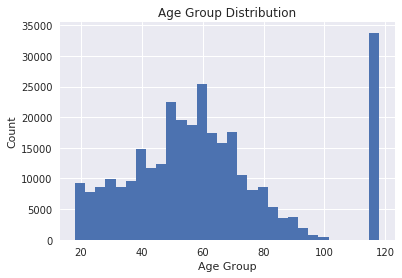

In [344]:
final_df.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution'); #the below chart has many values with age of 118

In [345]:
final_df["age"].isna().sum(), final_df["income"].isna().sum()

(0, 33772)

In [346]:
final_df[final_df["income"].isnull()].describe()

,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,income,difficulty,duration,reward,web,mobile,email,social,event_id
count,33772.000000,33772.000000,33772.000000,33772.000000,33772.000000,18776.000000,14996.000000,33772.0,0.0,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.0,18776.000000,33772.000000
mean,363.760038,0.033608,0.289471,0.232885,0.444036,5.555922,2.701358,118.0,NaN,7.532115,6.496059,4.241319,0.807733,0.924159,1.0,0.646570,1.221781
std,200.045060,0.180220,0.453523,0.422676,0.496866,3.105575,5.755461,0.0,NaN,5.097801,2.157126,3.376030,0.394092,0.264751,0.0,0.478047,0.904862
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,118.0,NaN,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,180.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.740000,118.0,NaN,5.000000,5.000000,2.000000,1.000000,1.000000,1.0,0.000000,0.000000
50%,408.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.710000,118.0,NaN,7.000000,7.000000,3.000000,1.000000,1.000000,1.0,1.000000,1.000000
75%,522.000000,0.000000,1.000000,0.000000,1.000000,8.000000,3.292500,118.0,NaN,10.000000,7.000000,5.000000,1.000000,1.000000,1.0,1.000000,2.000000
max,714.000000,1.000000,1.000000,1.000000,1.000000,10.000000,161.440000,118.0,NaN,20.000000,10.000000,10.000000,1.000000,1.000000,1.0,1.000000,3.000000


###### Thus, we can see that age is 118 whenever income is a nan value

In [347]:
final_df['age'] = final_df['age'].replace(118, np.nan)

In [348]:
#after replacing 118 with nan values
final_df["age"].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

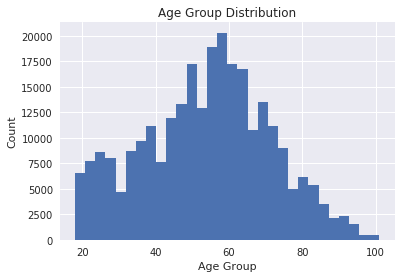

In [349]:
final_df.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

In [350]:
#11% of the data has nan values in age
final_df["age"].isna().sum()*100/len(final_df)

11.017374907840566

#### For Income


- Income is missing for 11% of the data
- Average income of a customer is ~64000

In [351]:
final_df["income"].describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

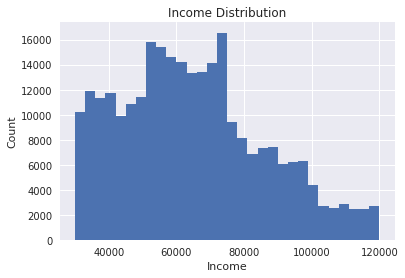

In [352]:
final_df.income.hist(bins = 30)
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Distribution');

In [353]:
#11% of the data has nan values in income
final_df["income"].isna().sum()*100/len(final_df)

11.017374907840566

#### For Gender


- Gender is missing for 11% of the data
- Males constitute about ~51% of the data

In [354]:
final_df["gender"].value_counts()*100/len(final_df)

M    50.790451
F    36.896723
O     1.295452
Name: gender, dtype: float64

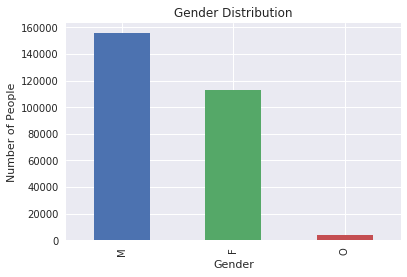

In [355]:
ax = final_df.gender.value_counts()
ax.plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

In [356]:
# 11% of the data has nan values in gender
final_df["gender"].isna().sum()*100/len(final_df)

11.017374907840566

In [357]:
final_df[final_df["income"].isnull()]["gender"].unique()

array([None], dtype=object)

### 2. On Offer Data

In [358]:
offer_received = final_df[final_df['offer received'] == 1].offer_type.value_counts()
offer_viewed = final_df[final_df['offer viewed'] == 1].offer_type.value_counts()
offer_completed = final_df[final_df['offer completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed 

(discount         30543
 bogo             30499
 informational    15235
 Name: offer_type, dtype: int64, bogo             25449
 discount         21445
 informational    10831
 Name: offer_type, dtype: int64, discount    17910
 bogo        15669
 Name: offer_type, dtype: int64)

In [359]:
df_groupby=pd.DataFrame(final_df.groupby("offer_type")["event"].value_counts()).rename(columns={"event":"event type counts"})
df_groupby.reset_index(inplace=True)
counts= list(pd.DataFrame(df_groupby.groupby("offer_type")["event type counts"].sum()).iloc[:,-1])
df_groupby["count %"] = 0
for i in range(len(df_groupby)):
    
    if df_groupby.iloc[i, 0]=="bogo":
        df_groupby.iloc[i,3] = df_groupby.iloc[i,2]*100/counts[0]
        
    elif df_groupby.iloc[i, 0]=="discount":
        df_groupby.iloc[i,3] = df_groupby.iloc[i,2]*100/counts[1]
        
    else:
        df_groupby.iloc[i,3] = df_groupby.iloc[i,2]*100/counts[2]

df_groupby
#it can be inferred that even though bogo offers were viewed more but discount offers were completed more

,offer_type,event,event type counts,count %
0,bogo,offer received,30499,42.586257
1,bogo,offer viewed,25449,35.534859
2,bogo,offer completed,15669,21.878884
3,discount,offer received,30543,43.696529
4,discount,offer viewed,21445,30.680420
5,discount,offer completed,17910,25.623051
6,informational,offer received,15235,58.447786
7,informational,offer viewed,10831,41.552214


In [360]:
counts

[71617, 69898, 26066]

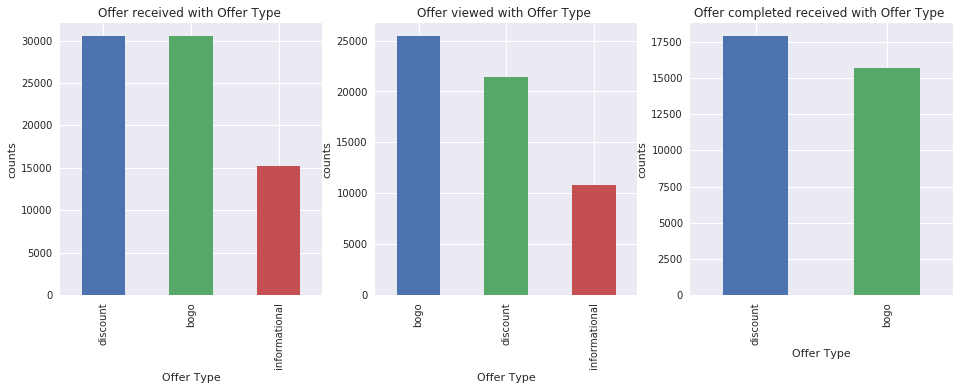

In [361]:
plt.subplot(131)
offer_received = final_df[final_df['offer received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(14, 5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = final_df[final_df['offer viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(17, 5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = final_df[final_df['offer completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(16, 5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');


In [362]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_id_info = pd.DataFrame(offer_dict, index=[0])
offer_id_info = offer_id_info.T

offer_id_info.reset_index(inplace=True)
offer_id_info=offer_id_info.rename(columns={"index":"offer no.", 0:"offer id"})

offer_id_info = pd.merge(offer_id_info, portfolio, on='offer id')
offer_id_info.drop(["difficulty", "duration", "reward"], axis=1, inplace=True)

In [363]:
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [364]:
offer_id_info["Offer and Channel"] = offer_id_info["offer_type"].astype(str) + " " + offer_id_info["channels"].astype(str)
offer_map_dict = pd.Series(offer_id_info["Offer and Channel"].values, index=offer_id_info["offer no."]).to_dict()

#map offer ids to the encoded offer description ids
final_df['offer id new'] = final_df['offer id'].map(offer_map_dict)

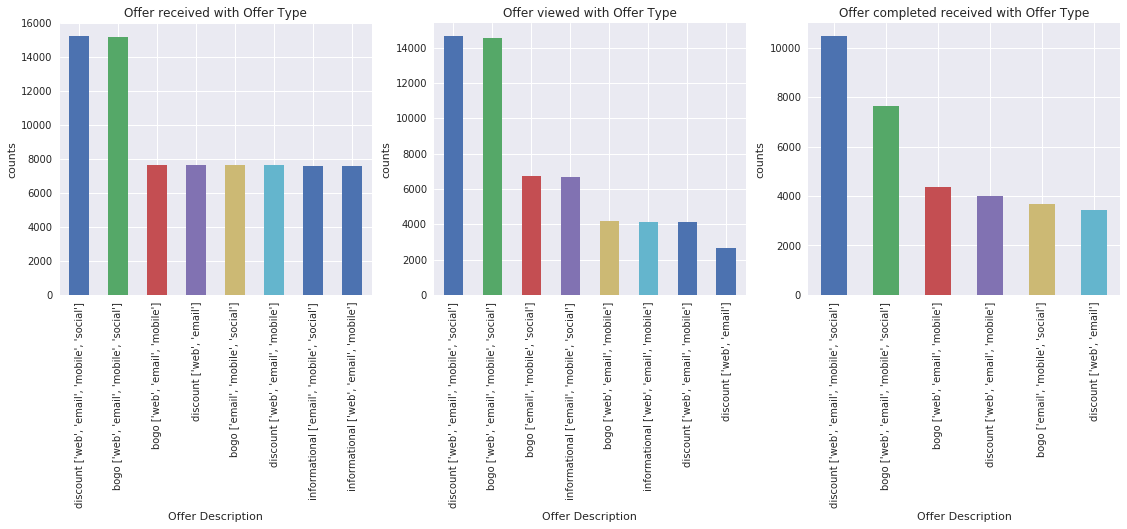

In [365]:
plt.subplot(131)
offer_received = final_df[final_df['offer received'] == 1]["offer id new"].value_counts()
offer_received.plot(kind='bar', figsize=(16,5))
plt.ylabel('counts')
plt.xlabel('Offer Description')
plt.title('Offer received with Offer Type');

plt.subplot(132)
offer_viewed = final_df[final_df['offer viewed'] == 1]["offer id new"].value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,5))
plt.ylabel('counts')
plt.xlabel('Offer Description')
plt.title('Offer viewed with Offer Type');

plt.subplot(133)
offer_completed = final_df[final_df['offer completed'] == 1]["offer id new"].value_counts()
offer_completed.plot(kind='bar' , figsize=(19,5))
plt.ylabel('counts')
plt.xlabel('Offer Description')
plt.title('Offer completed received with Offer Type');

##### Creating intervals for Income and Age

In [366]:
final_df['Income_Interval'] = pd.cut(final_df['income'], bins=np.arange(30000,130000,15000), include_lowest=True)

In [367]:
bin_list = [18, 40, 60, 80, 101]
final_df["Age_Interval"] = pd.cut(final_df['age'], bins=bin_list, include_lowest=True)

In [368]:
final_df.head(2)

,event,customer_id,time,offer completed,offer received,offer viewed,transaction,offer id,amount,age,...,offer_type,reward,web,mobile,email,social,event_id,offer id new,Income_Interval,Age_Interval
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.0,NaN,75.0,...,bogo,5.0,1.0,1.0,1.0,0.0,0,"bogo ['web', 'email', 'mobile']","(90000.0, 105000.0]","(60.0, 80.0]"
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.0,NaN,75.0,...,bogo,5.0,1.0,1.0,1.0,0.0,1,"bogo ['web', 'email', 'mobile']","(90000.0, 105000.0]","(60.0, 80.0]"


### Income and Age Analysis on a Gender Level

In [369]:
#subsetting data for "Males" & "Females"
final_df_m = final_df[final_df["gender"]=="M"]
final_df_w = final_df[final_df["gender"]=="F"]

#### Income wise analysis for Males

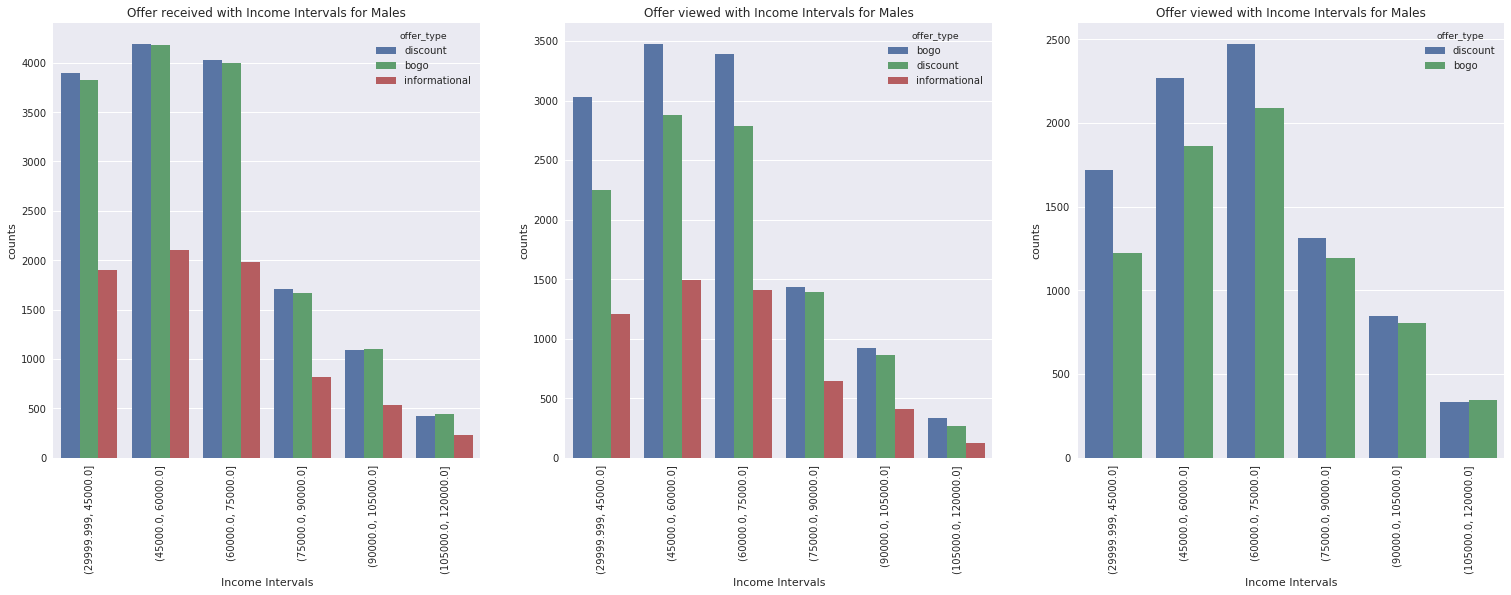

In [631]:
plt.subplot(131)
offer_received = final_df_m[final_df_m['offer received'] == 1]
final_df_m_plot= pd.DataFrame(offer_received.groupby(["Income_Interval"])["offer_type"].value_counts())
final_df_m_plot = pd.DataFrame(final_df_m_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_m_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Income_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_m_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer received with Income Intervals for Males');

plt.subplot(132)
offer_viewed = final_df_m[final_df_m['offer viewed'] == 1]
final_df_m_plot= pd.DataFrame(offer_viewed.groupby(["Income_Interval"])["offer_type"].value_counts())
final_df_m_plot = pd.DataFrame(final_df_m_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_m_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Income_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_m_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer viewed with Income Intervals for Males');

plt.subplot(133)
offer_completed = final_df_m[final_df_m['offer completed'] == 1]
final_df_m_plot= pd.DataFrame(offer_completed.groupby(["Income_Interval"])["offer_type"].value_counts())
final_df_m_plot = pd.DataFrame(final_df_m_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_m_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Income_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_m_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer viewed with Income Intervals for Males');

#### Income wise analysis for Females

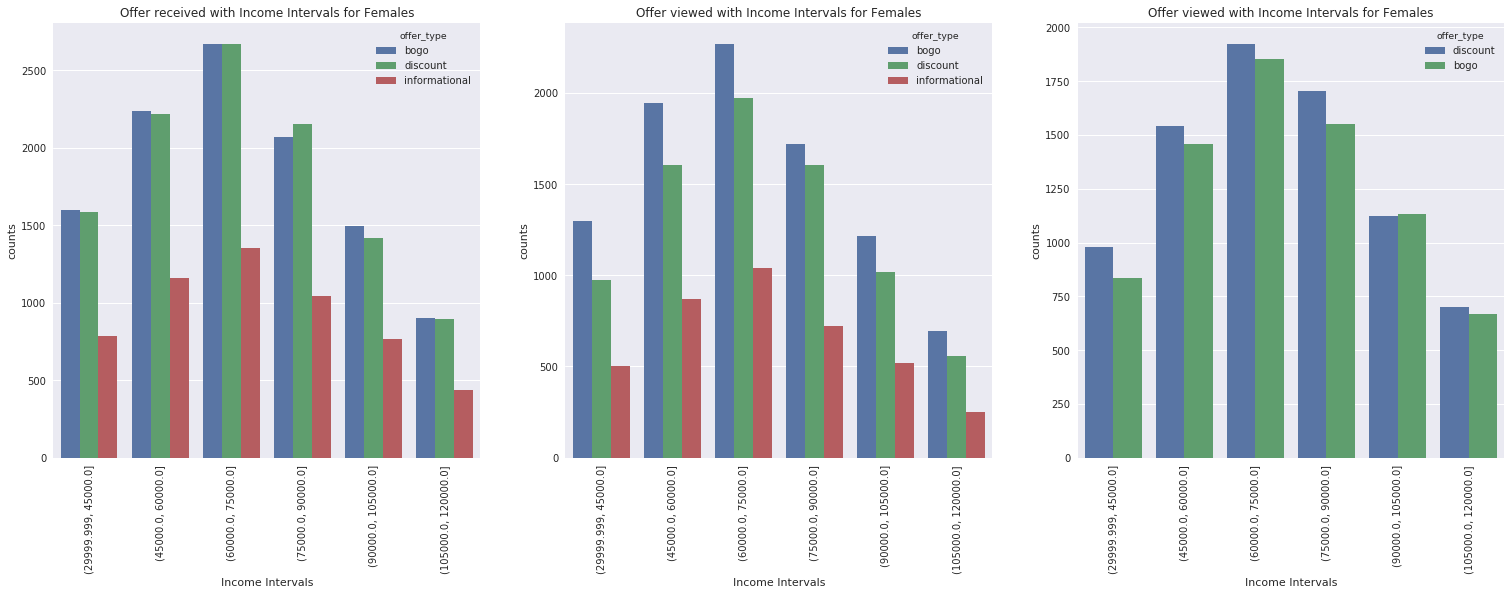

In [630]:
plt.subplot(131)
offer_received = final_df_w[final_df_w['offer received'] == 1]
final_df_w_plot= pd.DataFrame(offer_received.groupby(["Income_Interval"])["offer_type"].value_counts())
final_df_w_plot = pd.DataFrame(final_df_w_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_w_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Income_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_w_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer received with Income Intervals for Females');

plt.subplot(132)
offer_viewed = final_df_w[final_df_w['offer viewed'] == 1]
final_df_w_plot= pd.DataFrame(offer_viewed.groupby(["Income_Interval"])["offer_type"].value_counts())
final_df_w_plot = pd.DataFrame(final_df_w_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_w_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Income_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_w_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer viewed with Income Intervals for Females');

plt.subplot(133)
offer_completed = final_df_w[final_df_w['offer completed'] == 1]
final_df_w_plot= pd.DataFrame(offer_completed.groupby(["Income_Interval"])["offer_type"].value_counts())
final_df_w_plot = pd.DataFrame(final_df_w_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_w_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Income_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_w_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer viewed with Income Intervals for Females');

#### Age wise analysis for Males

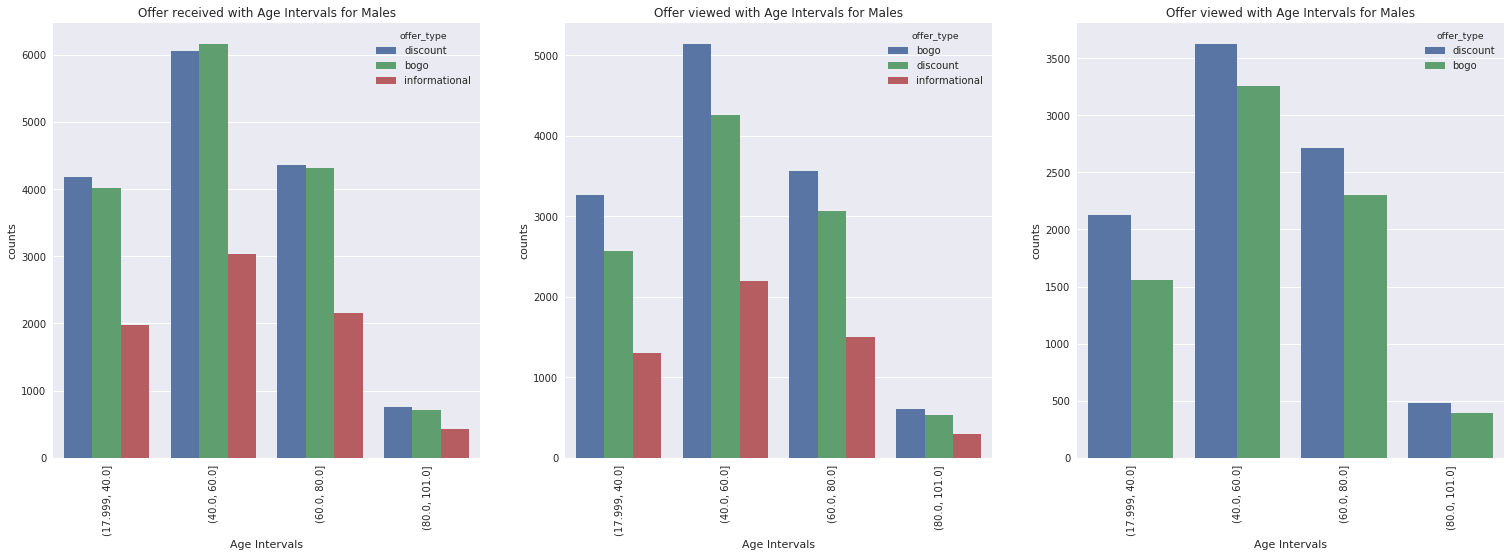

In [632]:
plt.subplot(131)
offer_received = final_df_m[final_df_m['offer received'] == 1]
final_df_m_plot= pd.DataFrame(offer_received.groupby(["Age_Interval"])["offer_type"].value_counts())
final_df_m_plot = pd.DataFrame(final_df_m_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_m_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Age_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_m_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer received with Age Intervals for Males');

plt.subplot(132)
offer_viewed = final_df_m[final_df_m['offer viewed'] == 1]
final_df_m_plot= pd.DataFrame(offer_viewed.groupby(["Age_Interval"])["offer_type"].value_counts())
final_df_m_plot = pd.DataFrame(final_df_m_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_m_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Age_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_m_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer viewed with Age Intervals for Males');

plt.subplot(133)
offer_completed = final_df_m[final_df_m['offer completed'] == 1]
final_df_m_plot= pd.DataFrame(offer_completed.groupby(["Age_Interval"])["offer_type"].value_counts())
final_df_m_plot = pd.DataFrame(final_df_m_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_m_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Age_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_m_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer viewed with Age Intervals for Males');

#### Age wise analysis for Females

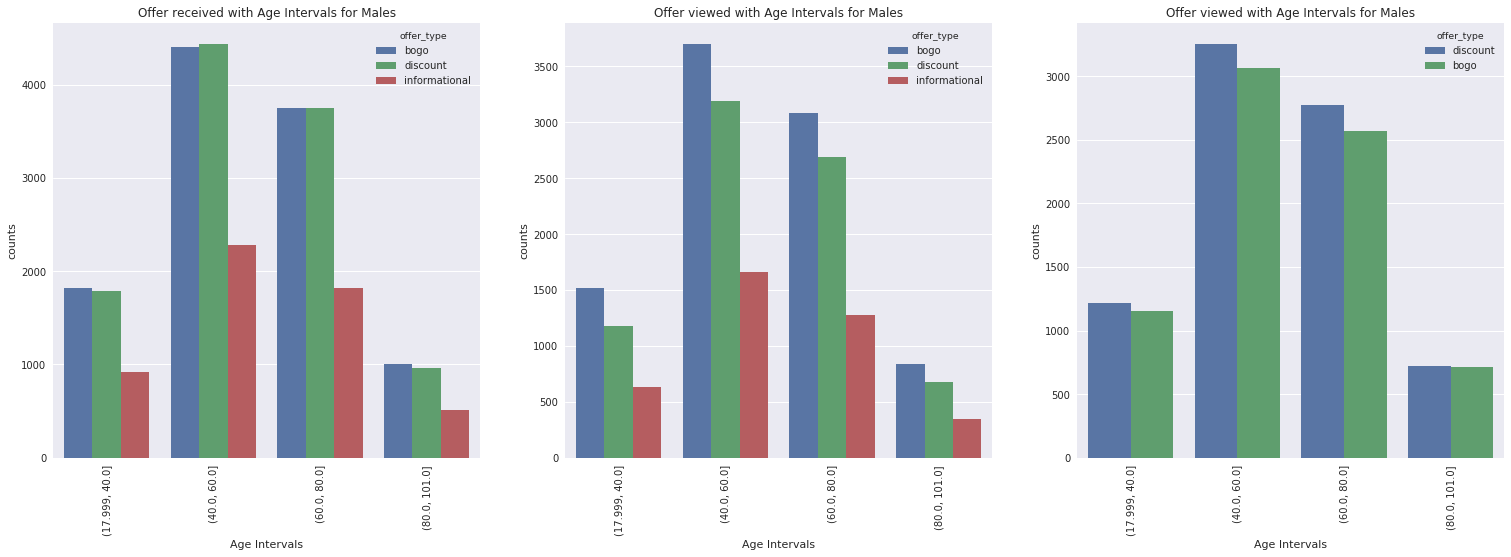

In [633]:
plt.subplot(131)
offer_received = final_df_w[final_df_w['offer received'] == 1]
final_df_w_plot= pd.DataFrame(offer_received.groupby(["Age_Interval"])["offer_type"].value_counts())
final_df_w_plot = pd.DataFrame(final_df_w_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_w_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Age_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_w_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer received with Age Intervals for Males');

plt.subplot(132)
offer_viewed = final_df_w[final_df_w['offer viewed'] == 1]
final_df_w_plot= pd.DataFrame(offer_viewed.groupby(["Age_Interval"])["offer_type"].value_counts())
final_df_w_plot = pd.DataFrame(final_df_w_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_w_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Age_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_w_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer viewed with Age Intervals for Males');

plt.subplot(133)
offer_completed = final_df_w[final_df_w['offer completed'] == 1]
final_df_w_plot= pd.DataFrame(offer_completed.groupby(["Age_Interval"])["offer_type"].value_counts())
final_df_w_plot = pd.DataFrame(final_df_w_plot).rename(columns={"offer_type":"Offer Type Count"})
final_df_w_plot.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(26, 8)})
sns.barplot(x = 'Age_Interval',
            y = 'Offer Type Count',
            hue = 'offer_type',
            data = final_df_w_plot)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer viewed with Age Intervals for Males');

### Modeling and Predective Analysis

##### Preparing Datasets

In [375]:
#offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [377]:
#map event_ids to the encoded event ids
final_df['offer id'] = final_df['offer id'].map(offer_dict)

##Removing nan rows and splitting offer and transaction data
final_df_clean = final_df[final_df['income'].notna()]
offer_data = final_df_clean[final_df_clean["transaction"]==0]
trans_data = final_df_clean[final_df_clean["transaction"]==1]

offer_data["Membership Year"] = offer_data.apply(lambda x: x["became_member_on"].year, axis=1)
offer_data["time_days"] = offer_data.apply(lambda x: int(round(x["time"]/24)), axis=1)
trans_data["time_days"] = trans_data.apply(lambda x: int(round(x["time"]/24)), axis=1)

offer_data.reset_index(inplace=True, drop=True)
trans_data.reset_index(inplace=True, drop=True)

offer_data.drop(["event","transaction", "amount", "became_member_on", "channels", "event_id", "offer id new"], inplace=True, axis=1)
trans_data = trans_data[["customer_id","time","transaction","amount"]]

profile = profile.dropna()
profile.reset_index(inplace=True, drop=True)
profile["Membership Year"] = profile.apply(lambda x: x["became_member_on"].year, axis=1)
profile.drop(["became_member_on"], inplace=True, axis=1)

In [378]:
trans_data.isna().sum() #no nan values

customer_id    0
time           0
transaction    0
amount         0
dtype: int64

In [379]:
offer_data.isna().sum() #no nan values

customer_id        0
time               0
offer completed    0
offer received     0
offer viewed       0
offer id           0
age                0
gender             0
income             0
difficulty         0
duration           0
offer_type         0
reward             0
web                0
mobile             0
email              0
social             0
Income_Interval    0
Age_Interval       0
Membership Year    0
time_days          0
dtype: int64

#### Creating Features

In [380]:
offer_data["customer_id"].nunique(), trans_data["customer_id"].nunique()

(14820, 14492)

In [391]:
trans_data["time_days"] = trans_data.apply(lambda x: int(round(x["time"]/24)), axis=1)
trans_data.head()

,customer_id,time,transaction,amount,time_days
0,78afa995795e4d85b5d9ceeca43f5fef,132,1,19.89,6
1,78afa995795e4d85b5d9ceeca43f5fef,144,1,17.78,6
2,78afa995795e4d85b5d9ceeca43f5fef,222,1,19.67,9
3,78afa995795e4d85b5d9ceeca43f5fef,240,1,29.72,10
4,78afa995795e4d85b5d9ceeca43f5fef,378,1,23.93,16


In [392]:
portfolio.head()

,channels,difficulty,duration,offer id,offer_type,reward,web,mobile,email,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


### Preparing Model Data


For each customer, apply the following algorithm:
1. Select a customer's profile  
2. Select offer data for a specific customer
3. For the same customer selected in step 2, select their transaction data
4. Initialize DataFrames that describe when a customer receives, views, and completes an offer
5. Iterate over each offer a customer receives
    - Initialize the current offer id  
    - Look-up a description of the current offer  
    - Initialize the time period when an offer is valid
    - Initialize a Boolean array that select customer transactions that fall within the valid offer time window
    - Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)  
    - Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
    - Determine whether the current offer was successful
        - For an offer to be successful a customer has to view and complete it  
    - Select customer transactions that occurred within the current offer valid time window  


In [393]:
def create_offeranalysis_dataset(profile, portfolio, offer_data, transaction):
    """ Creates an analytic dataset from the following Starbucks challenge 
    datasets:

    * portfolio.json - Contains offer ids and meta data (duration, type,
                       etc.)

    * profile.json - demographic data for each customer

    * transcript.json - records for transactions, offers received, offers
                        viewed, and offers completed
                        
    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer

        portfolio: Contains offer ids and meta data (duration, type, etc.)

        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions

    OUTPUT:
        clean_data: DataFrame that characterizes the effectiveness of
                    customer offers"""
    clean_data = []
    customerid_list = offer_data['customer_id'].unique()

    for idx in tqdm.tqdm(range(len(customerid_list))):

        clean_data.extend(create_combined_records(customerid_list[idx],
                                                  portfolio,
                                                  profile,
                                                  offer_data,
                                                  transaction))

    clean_data = pd.DataFrame(clean_data)

    # Initialize a list that describes the desired output DataFrame


    clean_data = clean_data.sort_values('time')
    return clean_data.reset_index(drop=True)

def create_combined_records(customer_id, portfolio, profile, offer_data, transaction):
    """ 
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer

    INPUT:
        customer_id: String that refers to a specific customer

        profile: DataFrame that contains demographic data for each 
                 customer
                 
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)

        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    # Select a customer's profile
    cur_customer = profile[profile['customer_id'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = offer_data['customer_id'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customer_id')
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    # Select transactions for a specific customer
    select_transaction = transaction['customer_id'] == customer_id
    customer_transaction_data = transaction[select_transaction]

    customer_transaction_data =\
        customer_transaction_data.drop(columns='customer_id')

    customer_transaction_data =\
        customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    event_type = ['offer completed',
                  'offer received',
                  'offer viewed']

    offer_received =\
        customer_offer_data[customer_offer_data['offer received'] == 1]

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =\
        customer_offer_data[customer_offer_data['offer viewed'] == 1]

    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =\
        customer_offer_data[customer_offer_data['offer completed'] == 1]

    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)
    
    #print(offer_received.head())
    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offer id']
        
        # Look-up a description of the current offer
        cur_offer = portfolio[portfolio['offer id'] == cur_offer_id]
        durationdays = cur_offer['duration'].values[0]

        # Initialize the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['time_days']

        cur_offer_endtime =\
            offer_received.iloc[idx]['time_days'] + durationdays

        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction =\
            np.logical_and(customer_transaction_data['time_days'] >=
                           cur_offer_startime,
                           customer_transaction_data['time_days'] <=
                           cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer completes an offer (this array may not contain any True
        # values)
        select_offer_completed =\
            np.logical_and(offer_completed['time_days'] >= cur_offer_startime,
                           offer_completed['time_days'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer (this array may not contain any True
        # values)
        select_offer_viewed =\
            np.logical_and(offer_viewed['time_days'] >= cur_offer_startime,
                           offer_viewed['time_days'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful =\
            select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer
        # valid time window
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize a dictionary that describes the current customer offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(cur_row)

    return rows

In [402]:
# commented out because takes a lot of time to run
# fn_result_df = create_offeranalysis_dataset(profile, portfolio, offer_data, trans_data)

In [640]:
# fn_result_df.to_csv("Model Data.csv")
fn_result_df = pd.read_csv("Model Data.csv")
fn_result_df.drop("Unnamed: 0", inplace=True, axis=1)
fn_result_df.head()

,Membership Year,customer_id,customerid,difficulty,duration,email,gender,income,mobile,offer id,offer_type,offerid,offersuccessful,reward,social,time,totalamount,web
0,2017,78afa995795e4d85b5d9ceeca43f5fef,78afa995795e4d85b5d9ceeca43f5fef,5,7,1,F,100000.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0,0,37.67,1
1,2018,d1485166e0f44d2f8be9ee8c4a06a026,d1485166e0f44d2f8be9ee8c4a06a026,0,3,1,F,92000.0,1,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,23.30,0
2,2018,9e0d618d75954225adc8cff0c3e420e8,9e0d618d75954225adc8cff0c3e420e8,5,7,1,M,49000.0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,0,0,0.00,1
3,2016,aa374a0deb7743aa9505b6611f350b09,aa374a0deb7743aa9505b6611f350b09,0,3,1,F,87000.0,1,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,0.00,0
4,2018,44f1f503047642ac83f70785c4992032,44f1f503047642ac83f70785c4992032,10,7,1,M,89000.0,1,ae264e3637204a6fb9bb56bc8210ddfd,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1,0,27.96,0


In [457]:
#creating a dataset of age and income to merge it with the model data
age_income_df = final_df.drop_duplicates(["customer_id"])
age_income_df = age_income_df[["customer_id", "Income_Interval", "Age_Interval"]]
age_income_df = age_income_df.dropna()
age_income_df.reset_index(inplace=True, drop=True)

In [462]:
age_income_df.isna().sum()

customer_id        0
Income_Interval    0
Age_Interval       0
dtype: int64

In [461]:
age_income_df.head()

,customer_id,Income_Interval,Age_Interval
0,78afa995795e4d85b5d9ceeca43f5fef,"(90000.0, 105000.0]","(60.0, 80.0]"
1,e2127556f4f64592b11af22de27a7932,"(60000.0, 75000.0]","(60.0, 80.0]"
2,389bc3fa690240e798340f5a15918d5c,"(45000.0, 60000.0]","(60.0, 80.0]"
3,2eeac8d8feae4a8cad5a6af0499a211d,"(45000.0, 60000.0]","(40.0, 60.0]"
4,aa4862eba776480b8bb9c68455b8c2e1,"(45000.0, 60000.0]","(60.0, 80.0]"


In [570]:
model_data= fn_result_df[['offersuccessful',
 'Membership Year',
 'totalamount',
 'difficulty',
 'duration',
 'gender',
 'income',
 'offer_type',
 'reward',
 'mobile',
 'email',
 'social',
 'web',
 'time',
 'customer_id']]

In [571]:
model_data = pd.merge(model_data, age_income_df, on='customer_id')

In [572]:
#one hot encoding the gender data
# dummy = pd.get_dummies(model_data['gender'])
# model_data = pd.concat([model_data, dummy], axis=1)

#one hot encoding the Membership Year data
dummy = pd.get_dummies(model_data['Membership Year'])
model_data = pd.concat([model_data, dummy], axis=1)

#one hot encoding the Offer Type data
dummy = pd.get_dummies(model_data['offer_type'])
model_data = pd.concat([model_data, dummy], axis=1)

#one hot encoding the Income interval data
# dummy = pd.get_dummies(model_data['Income_Interval'])
# model_data = pd.concat([model_data, dummy], axis=1)

#one hot encoding the Age interval data
dummy = pd.get_dummies(model_data['Age_Interval'])
model_data = pd.concat([model_data, dummy], axis=1)

#dropping redundant columns
model_data.drop(["gender","Membership Year", "offer_type", "Income_Interval", "Age_Interval", "customer_id"], inplace=True, axis=1)

In [574]:
model_data.head(2)

,offersuccessful,totalamount,difficulty,duration,income,reward,mobile,email,social,web,...,2016,2017,2018,bogo,discount,informational,"(17.999, 40.0]","(40.0, 60.0]","(60.0, 80.0]","(80.0, 101.0]"
0,1,37.67,5,7,100000.0,5,1,1,0,1,...,0,1,0,1,0,0,0,0,1,0
1,0,49.39,0,3,100000.0,0,1,1,1,0,...,0,1,0,0,0,1,0,0,1,0


In [575]:
feature_data.isna().sum()

totalamount       0
difficulty        0
duration          0
income            0
reward            0
mobile            0
email             0
social            0
web               0
time              0
F                 0
M                 0
O                 0
2013              0
2014              0
2015              0
2016              0
2017              0
2018              0
bogo              0
discount          0
informational     0
(17.999, 40.0]    0
(40.0, 60.0]      0
(60.0, 80.0]      0
(80.0, 101.0]     0
dtype: int64

In [604]:
target_data = model_data["offersuccessful"]
feature_data = model_data.drop(["offersuccessful", "totalamount","time"], axis=1)

In [605]:
feature_data.columns

Index([   'difficulty',      'duration',        'income',        'reward',
              'mobile',         'email',        'social',           'web',
                  2013,            2014,            2015,            2016,
                  2017,            2018,          'bogo',      'discount',
       'informational',  (17.999, 40.0],    (40.0, 60.0],    (60.0, 80.0],
         (80.0, 101.0]],
      dtype='object')

### Test Train Split

In [606]:
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.2, random_state=24)

In [607]:
rf_clf = RandomForestClassifier()

In [608]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [609]:
y_pred_rf = rf_clf.predict(X_test)

In [610]:
print(classification_report(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.69      0.69      0.69      6851
          1       0.67      0.67      0.67      6450

avg / total       0.68      0.68      0.68     13301



In [634]:
## Baseline model gave us an F1 score of 0.68

#### Implementing Random Search CV for hyperparameter tuning

In [615]:
rf_clf = RandomForestClassifier(random_state=24)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11, 2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=24,
                               n_jobs = -1)

#commented out to save time
#rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   1.0s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   1.0s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=7, total=   1.0s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.4s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.7s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=9, total=   3.4s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=24, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 5, 7, 9, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=24, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [617]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 9}

In [624]:
rf_best = RandomForestClassifier(n_estimators=200, min_samples_split= 2,
 min_samples_leaf= 4,
 max_features="auto",
 max_depth= 9)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Text(0.5,1,'Random Forest Estimated Feature Importance')

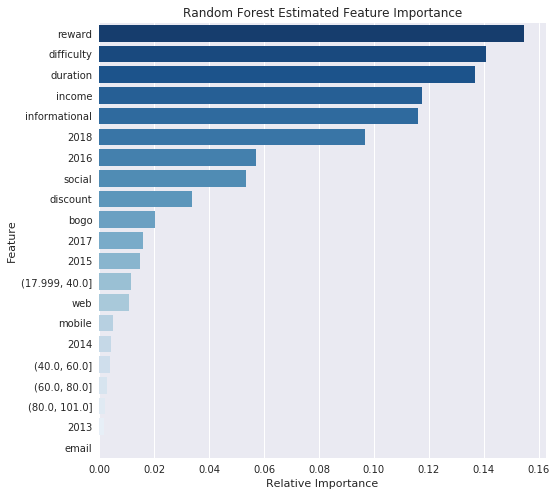

In [626]:
relative_importance = rf_best.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(feature_data.columns,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

In [627]:
y_pred_best = rf_random.predict(X_test)
print(classification_report(y_test, y_pred_best))

             precision    recall  f1-score   support

          0       0.75      0.69      0.72      6851
          1       0.70      0.75      0.72      6450

avg / total       0.72      0.72      0.72     13301



In [635]:
accuracy_score(y_test, y_pred_best)

0.7209984211713405

In [636]:
print("Therefore, final model's accuracy is 72% and F1-score is 72%")

Therefore, final model's accuracy is 72% and F1-score is 72%


### Conclusion

At first through EDA we observed that boho offers are viewed more but completed less and this pattern was observed for almost all age and income groups in both males and females

After that we defined a problem to make a classification model to predict whether a customer will complete an offer or not. We used a random forest model for our classifier and tuned the hyperparameters using randomsearchcv, the best parameters were:

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 9}

"[Feature importance](https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e)" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. This analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top four features based on their importance are:  
      
    1. Offer reward 
    2. Offer difficulty (how much money a customer must spend to complete an offer)   
    3. Offer duration    
    4. Customer's income  
    
Final Random Forest Model's results: Accuracy 0.72 and F1-score 72%

Note: Since it was mentioned that the student is free to analyze the data any way they see fit, I have only highlighted the use of one model. Although different models could also be applied but I am satisfied with the results with Random Forest Classifier because the relative feature importance is helpful to understand what drives completion of an offer.

### Appendix (contains extra/redudant analysis results)

#### Income wise analysis for Males

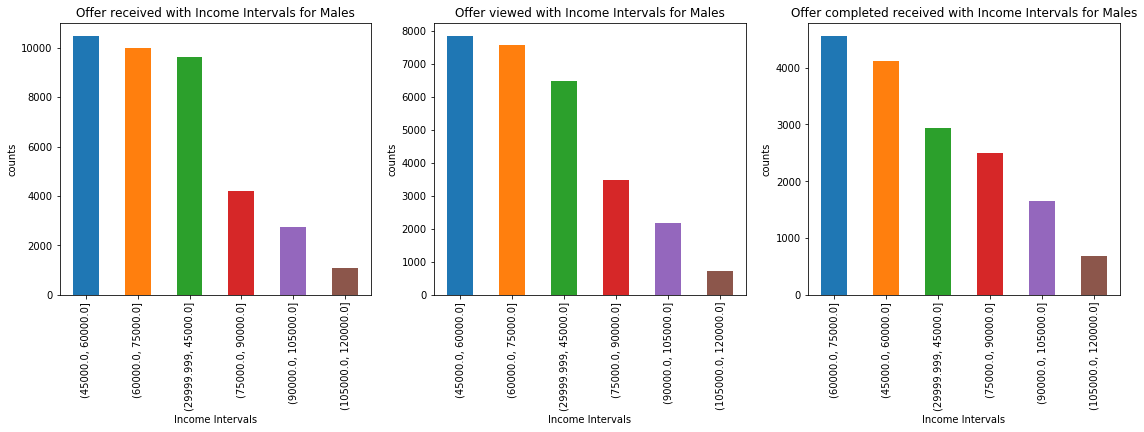

In [61]:
plt.subplot(131)
offer_received = final_df_m[final_df_m['offer received'] == 1]["Income_Interval"].value_counts()
offer_received.plot(kind='bar', figsize=(16,5))
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer received with Income Intervals for Males');

plt.subplot(132)
offer_viewed = final_df_m[final_df_m['offer viewed'] == 1]["Income_Interval"].value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,5))
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer viewed with Income Intervals for Males');

plt.subplot(133)
offer_completed = final_df_m[final_df_m['offer completed'] == 1]["Income_Interval"].value_counts()
offer_completed.plot(kind='bar' , figsize=(19,5))
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer completed received with Income Intervals for Males');

#### Income wise analysis for Females

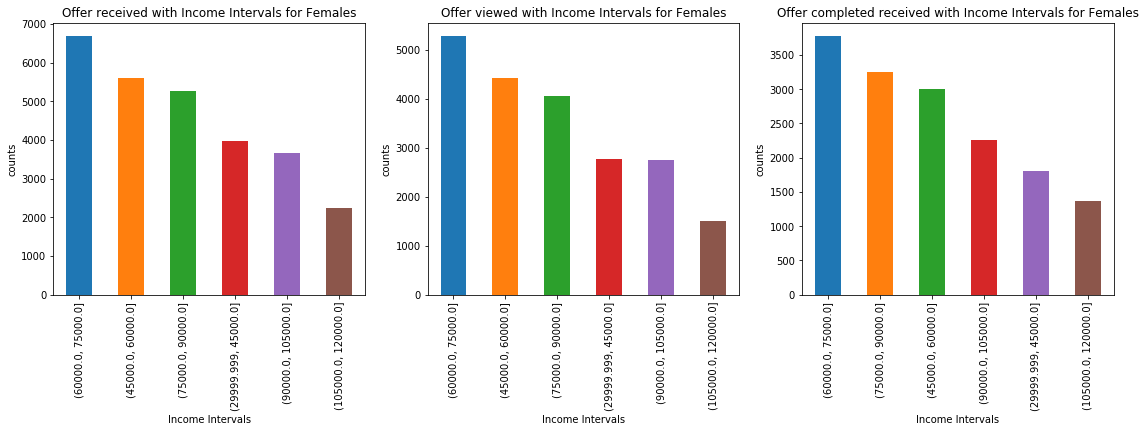

In [62]:
plt.subplot(131)
offer_received = final_df_w[final_df_w['offer received'] == 1]["Income_Interval"].value_counts()
offer_received.plot(kind='bar', figsize=(16,5))
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer received with Income Intervals for Females');

plt.subplot(132)
offer_viewed = final_df_w[final_df_w['offer viewed'] == 1]["Income_Interval"].value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,5))
plt.ylabel('counts')
plt.xlabel('Income Intervals')
plt.title('Offer viewed with Income Intervals for Females');

plt.subplot(133)
offer_completed = final_df_w[final_df_w['offer completed'] == 1]["Income_Interval"].value_counts()
offer_completed.plot(kind='bar' , figsize=(19,5))
plt.ylabel('counts')
plt.xlabel('Income Intervals')#### Income wise analysis for Males
plt.title('Offer completed received with Income Intervals for Females');

#### Age wise analysis for Males

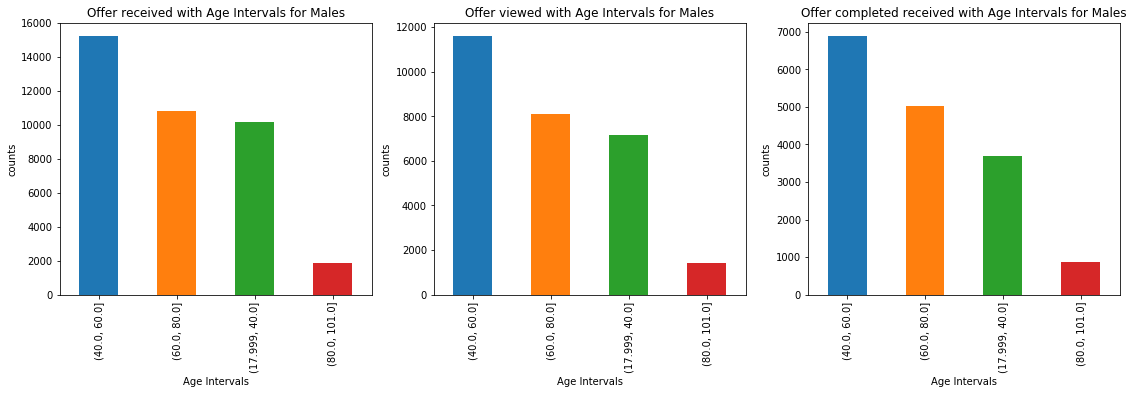

In [63]:
plt.subplot(131)
offer_received = final_df_m[final_df_m['offer received'] == 1]["Age_Interval"].value_counts()
offer_received.plot(kind='bar', figsize=(16,5))
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer received with Age Intervals for Males');

plt.subplot(132)
offer_viewed = final_df_m[final_df_m['offer viewed'] == 1]["Age_Interval"].value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,5))
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer viewed with Age Intervals for Males');

plt.subplot(133)
offer_completed = final_df_m[final_df_m['offer completed'] == 1]["Age_Interval"].value_counts()
offer_completed.plot(kind='bar' , figsize=(19,5))
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer completed received with Age Intervals for Males');

#### Age wise analysis for Females

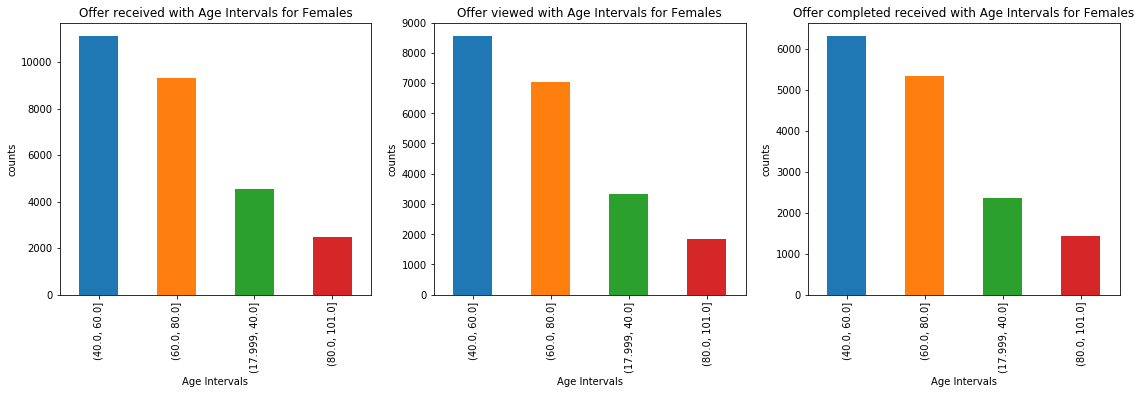

In [64]:
plt.subplot(131)
offer_received = final_df_w[final_df_w['offer received'] == 1]["Age_Interval"].value_counts()
offer_received.plot(kind='bar', figsize=(16,5))
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer received with Age Intervals for Females');

plt.subplot(132)
offer_viewed = final_df_w[final_df_w['offer viewed'] == 1]["Age_Interval"].value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,5))
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer viewed with Age Intervals for Females');

plt.subplot(133)
offer_completed = final_df_w[final_df_w['offer completed'] == 1]["Age_Interval"].value_counts()
offer_completed.plot(kind='bar' , figsize=(19,5))
plt.ylabel('counts')
plt.xlabel('Age Intervals')
plt.title('Offer completed received with Age Intervals for Females');